In [58]:
import  re
import pandas as pd
pd.options.display.max_colwidth = None
pd.options.display.float_format = '{:.2f}'.format

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import sshtunnel
import mysql.connector as connection

import folium
import geopandas as gpd
from shapely.geometry import LineString
from folium.plugins import HeatMap
from shapely.geometry import Point
from folium.plugins import MarkerCluster
from folium import plugins

### Load and preprocess data

In [3]:
def extract_terminal_name(x):
    if isinstance(x, str):
        pattern = r'Terminal (Capão da Imbuia|Pinheirinho|Portão|Bairro Alto|Barreirinha|Boa Vista|Boqueirão|Cabral|Cachoeira|Caiuá|Campina do Siqueira|Campo Comprido|Capão Raso|Carmo|Centenário|CIC|Fazendinha|Hauer|Maracanã|Oficinas|Pinhais|Santa Cândida|Santa Felicidade|Sítio Cercado|Tatuquara)'

        match = re.search(pattern, x)
        if match:
            return match.group()
    return x

In [4]:
## removing the hours between 0 and 4 (dawn)
vw_event = pd.read_parquet("events.parquet")
vw_event['hour'] = vw_event["event_timestamp"].dt.hour
vw_event = vw_event.query("hour not in [0,1,2,3,4]")

## removing the bus stop types (others, dawn bus and tourism line)
dim_bus_stop = pd.read_parquet("dim_bus_stop.parquet").query("type_norm not in (['Others','Dawn bus','Tourism line'])").drop(columns=['last_update'])
dim_bus_stop['name_normalized'] = np.where( (dim_bus_stop.type_norm == 'Bus terminal'),  dim_bus_stop.name , '')

dim_bus_stop['name_normalized'] = dim_bus_stop['name_normalized'].apply(extract_terminal_name)

In [5]:
# creating dummy ids for each terminal/platform
## here the dummy ids are just the sum of the ids of all points in the same bus station. It's a simple rule and it might work as the sum will generate a big number not related with the other points.

terminais_dummy_ids = dim_bus_stop.query("~name_normalized.isna() and name_normalized != ''").groupby(['name_normalized']).agg(dummy_legacy_id = ('legacy_id', 'sum')).reset_index()

In [6]:
dim_bus_stop = dim_bus_stop.merge(terminais_dummy_ids, on=['name_normalized'], how='left')

In [7]:
# just fill the dummy_legacy_id's with the legacy_id's for all remaining null fields, 

dim_bus_stop['dummy_legacy_id'] = np.where( (dim_bus_stop.name_normalized == '') , dim_bus_stop.legacy_id, dim_bus_stop.dummy_legacy_id)
dim_bus_stop['dummy_legacy_id'] = dim_bus_stop.dummy_legacy_id.astype(int)

In [8]:
vw_event = vw_event.merge(dim_bus_stop.filter(['legacy_id','dummy_legacy_id']), on='legacy_id')

In [9]:
# ----------------------------------------------------------
# Contabiliza a passagem dos veículos nos pontos de ônibus
# Notice that here we are using dummy legacy id's so all bus stops in the same bus terminal will be grouped as a single point
# ----------------------------------------------------------
paradas = []
for legacy_id in vw_event["dummy_legacy_id"].unique():
    aux = vw_event.query("dummy_legacy_id == @legacy_id").copy()
    aux["bus_availability"] = 1
    aux.index = aux["event_timestamp"]
    aux.sort_index(inplace = True)
    aux = aux.rolling(window = "10min", min_periods = 1, on = "event_timestamp", closed = "both").agg({"bus_availability": "sum"})
    aux.reset_index(inplace = True)
    aux["dummy_legacy_id"] = legacy_id
    aux["hour"] = aux["event_timestamp"].dt.hour
    paradas.append(aux)
paradas = pd.concat(paradas, ignore_index = True)

In [76]:
df = pd.merge(paradas, dim_bus_stop, on = "dummy_legacy_id")

In [77]:
# MERGE BUS TERMINAL POINTS

df_bus_availability = df.groupby(['dummy_legacy_id','name_normalized','type_norm','hour']).agg(bus_availability=('bus_availability','mean')).reset_index()

In [78]:
# Dicionário de mapeamento para substituir os valores
mapping = {
    "Bus terminal": "Terminal",
    "Street bus stop": "Ponto de rua",
    "Tube station": "Estação tubo"
}

# Substituindo os valores na coluna 'type_norm'
df_bus_availability['type_norm'] = df_bus_availability['type_norm'].map(mapping)

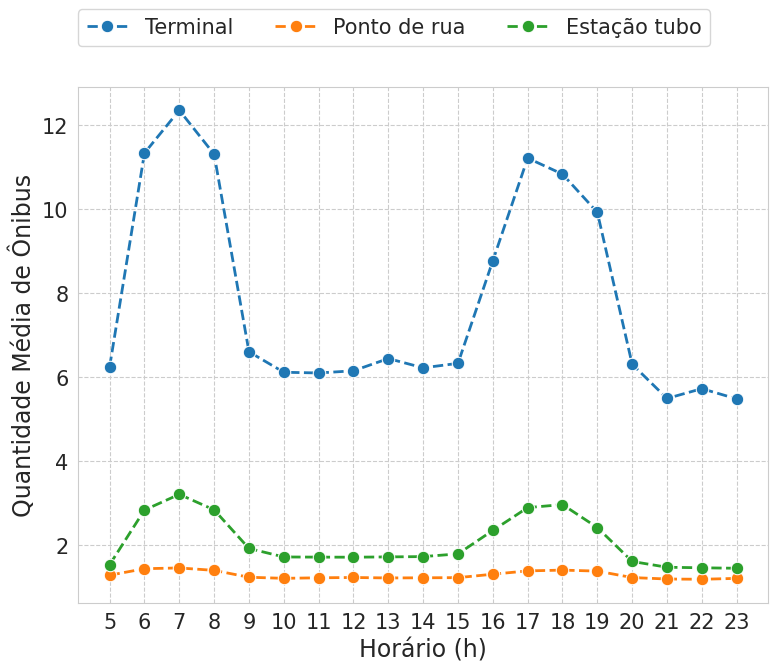

In [81]:
fig, axes = plt.subplots(figsize = (8.9, 6.7))
sns.set_style("whitegrid", {'grid.linestyle': '--'})
g = sns.lineplot(x = df_bus_availability.hour, y = df_bus_availability.bus_availability, estimator='mean', err_style = None, marker = 'o', markersize = 9, linestyle = "dashed", linewidth = 2, hue = df_bus_availability.type_norm, hue_order = ['Terminal', 'Ponto de rua', 'Estação tubo'], palette = sns.color_palette("tab10", 3), ax = axes)
g.set_xticks(range(5, 24))
g.legend(bbox_to_anchor = (0, 1.15), fontsize = 15, loc = "upper left", ncol = 3, borderaxespad = 0);
g.tick_params(labelsize = 15)
g.set_xlabel("Horário (h)", fontsize = 17)
g.set_ylabel("Quantidade Média de Ônibus", fontsize = 17)
plt.savefig('bus_availability.png', format='png', dpi=300);

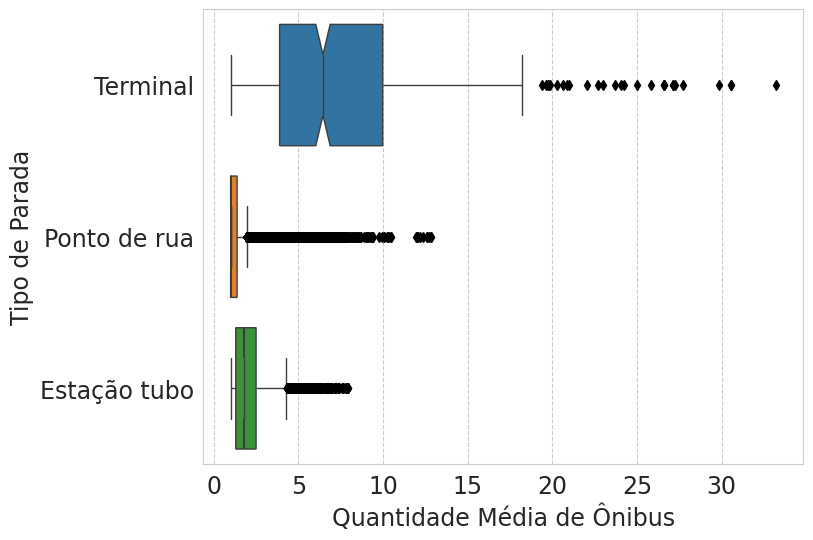

In [85]:
fig, axes = plt.subplots(figsize = (10, 6.5))
sns.set_style("whitegrid", {'grid.linestyle': '--'})
flierprops = dict(marker = 'd', markerfacecolor = 'black', markersize = 5,  markeredgecolor = 'black')
meanprops = dict(marker = '+', markerfacecolor = 'black', markersize = 10,  markeredgecolor = 'black')
g = sns.boxplot(x = df_bus_availability.bus_availability, y = df_bus_availability.type_norm, linewidth = 1.0, hue = df_bus_availability.type_norm, palette = sns.color_palette("tab10", 3), notch = True, order = ['Terminal', 'Ponto de rua', 'Estação tubo'], hue_order = ['Terminal', 'Ponto de rua', 'Estação tubo'], ax = axes, flierprops = flierprops, meanprops = meanprops)
g.tick_params(labelsize = 17)
g.set_xlabel("Quantidade Média de Ônibus", fontsize = 17)
g.set_ylabel("Tipo de Parada", fontsize = 17)
plt.subplots_adjust(left=0.3, right=0.9, bottom=0.2, top=0.9)
fig.savefig('daily_avg_bus_availability.png', format='png', dpi=300)

In [51]:
# ----------------------------------------------------------
# Seleciona apenas os pontos de ônibus e estaçoes tubo na rua
# ----------------------------------------------------------
df_bus_availability.query("type_norm in ['Ponto de rua', 'Estação tubo']", inplace = True)

In [52]:
df_bus_availability_day = (
                            df_bus_availability
                            .groupby(['dummy_legacy_id','type_norm'])
                            .agg(mean_bus_availability = ('bus_availability', 'mean')).sort_values(by='mean_bus_availability', ascending=False)
                        )

In [53]:
stat = [df_bus_availability_day.mean_bus_availability.count(),
        df_bus_availability_day.mean_bus_availability.min(), 
        df_bus_availability_day.mean_bus_availability.max(), 
        df_bus_availability_day.mean_bus_availability.quantile(0.25),
        df_bus_availability_day.mean_bus_availability.median(), 
        df_bus_availability_day.mean_bus_availability.quantile(0.75),
        df_bus_availability_day.mean_bus_availability.mean(), 
        df_bus_availability_day.mean_bus_availability.std()
        ]

df_bus_availability_day.mean_bus_availability.describe().to_frame().transpose()

,count,mean,std,min,25%,50%,75%,max
mean_bus_availability,6386.00,1.31,0.55,1.00,1.00,1.08,1.41,8.50


In [54]:
# ----------------------------------------------------------
# Seleciona apenas os outliers: Q3 + 1,5 * IIQ
# ----------------------------------------------------------
top = df_bus_availability_day.query("mean_bus_availability >= {0}".format(stat[5] + 1.5 * (stat[5] - stat[3]))).reset_index()

In [61]:
# -------------------------------------------------
# Constrói os agrupamentos a partir dos outliers
# -------------------------------------------------
base_date_0 = "2022-07-11"
base_date_1 = "2022-07-15"
ssh_username = "julio"
ssh_password = "jfzrpg93"

tunnel = sshtunnel.SSHTunnelForwarder(("200.134.10.26", 22), ssh_username = ssh_username, ssh_password = ssh_password, remote_bind_address = ("localhost", 3306))
tunnel.start()
mydb = connection.connect(user = "root", password = "123123123", host = "localhost", database = "busanalysis_dw", port = tunnel.local_bind_port, use_pure = True)

cluster_centroids = top.sort_values(by = "mean_bus_availability", ascending = False).dummy_legacy_id.to_list()
clusters = []
legacy_ids = []
c = 0
while len(cluster_centroids) > 0:
    cluster = pd.read_sql("""
                         SELECT bus_stop_clustered AS legacy_id,
                              CASE WHEN bus_stop_centre = bus_stop_clustered THEN 1 ELSE 0 END AS centre,
                              d 
                        FROM vw_cluster WHERE bus_stop_centre = {0}""".format(cluster_centroids[0]), mydb)
    
    cluster["cluster"] = c
    clusters.append(cluster)
    for item in cluster.legacy_id.to_list():        
        if item in cluster_centroids:
            cluster_centroids.remove(item)    
    cluster.query("legacy_id not in @legacy_ids", inplace = True)
    legacy_ids.extend(cluster.legacy_id.to_list())
    legacy_ids = list(dict.fromkeys(legacy_ids))    
    c = c + 1
mydb.close()
clusters = pd.concat(clusters, ignore_index = True)
bus_stop_clustered = pd.merge(clusters, dim_bus_stop, on = "legacy_id")

In [62]:
bus_stop_clustered.drop(columns=['name_normalized','dummy_legacy_id'], inplace=True)

In [63]:
df_bus_availability_day = df_bus_availability_day.reset_index()

In [64]:
# -------------------------------------------------
# Calcula as métricas do cluster
# -------------------------------------------------
cluster_metrics = []
cluster_details = []
for id in bus_stop_clustered.cluster.unique():    
    cluster = bus_stop_clustered.query("cluster == @id")
    centroid_legacy_id = cluster.query("centre == 1").legacy_id.to_numpy()[0]
    legacy_ids = cluster.legacy_id.to_list()

    aux = vw_event.query("legacy_id in @legacy_ids").copy()
    aux["bus_availability"] = 1
    aux.index = aux["event_timestamp"]
    aux.sort_index(inplace = True)
    aux = aux.rolling(window = "10min", min_periods = 1, on = "event_timestamp", closed = "both").agg({"bus_availability": "sum"})
    aux.reset_index(inplace = True)
    aux["hour"] = aux["event_timestamp"].dt.hour    
    aux["cluster"] = id

    c = {"cluster": id, 
         "cluster_bus_availability_mean": aux.bus_availability.mean(), 
         "cluster_bus_lines": len(vw_event.query("legacy_id in @legacy_ids").line_code.unique()), 
         "cluster_size": len(legacy_ids),
         "cluster_mean_distance_from_centre": cluster.d.mean(),
         "centroid_legacy_id": centroid_legacy_id,
         "centroid_mean_bus_availability": df_bus_availability_day.query("dummy_legacy_id == @centroid_legacy_id").mean_bus_availability.values[0],
         "centroid_bus_lines": len(vw_event.query("legacy_id == @centroid_legacy_id").line_code.unique())
         }
    
    cluster_metrics.append(c)    
    cluster_details.append(aux)

cluster_metrics = pd.DataFrame.from_dict(cluster_metrics)
cluster_details = pd.concat(cluster_details, ignore_index = True)

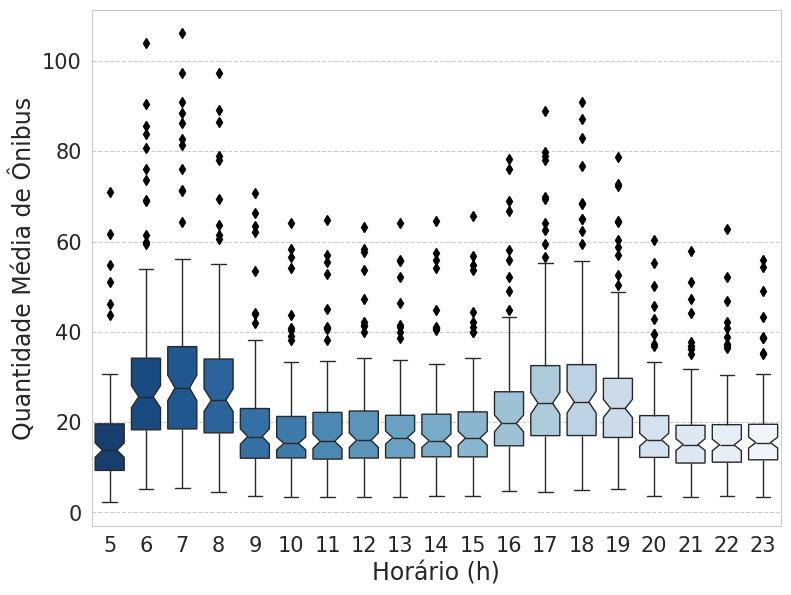

In [65]:
df = cluster_details.groupby(by = ["cluster", "hour"]).agg({"bus_availability": "mean"})
df.reset_index(inplace = True)

fig, axes = plt.subplots(figsize = (8.9, 6.7))
sns.set_style("whitegrid", {'grid.linestyle': '--'})
flierprops = dict(marker = 'd', markerfacecolor = 'black', markersize = 5,  markeredgecolor = 'black')
meanprops = dict(marker = '+', markerfacecolor = 'black', markersize = 10,  markeredgecolor = 'black')
g = sns.boxplot(x = df.hour, y = df.bus_availability, linewidth = 1.0, palette = sns.color_palette("Blues_r", len(df.hour.unique())), notch = True, showfliers = True, ax = axes, flierprops = flierprops, meanprops = meanprops)
g.tick_params(labelsize = 15)
g.set_xlabel("Horário (h)", fontsize = 17)
g.set_ylabel("Quantidade Média de Ônibus", fontsize = 17);
plt.savefig('cluster_avg_bus_availability.png', format='png', dpi=300)

In [41]:
df = pd.merge(cluster_metrics, dim_bus_stop, left_on = "centroid_legacy_id", right_on = "legacy_id")

In [67]:
import scipy

scipy.stats.pearsonr(x = cluster_metrics.cluster_bus_availability_mean, y = cluster_metrics.cluster_bus_lines)

PearsonRResult(statistic=0.7816139691487262, pvalue=1.238580020973676e-22)

In [45]:
## Correlacoes por faixa de horario
## Rodar as correlações em um período determinado: 6 às 9, 11 às 14 e 17 às 20 (júlio / altieris)

In [77]:
def generate_correlations(cluster, hour, plot_name, time_window, directory):
    cluster0 = bus_stop_clustered.query(f"cluster == {cluster}").legacy_id.to_list()
    centroid = bus_stop_clustered.query(f"cluster == {cluster} and centre ==1").legacy_id.values[0]
    
    data = paradas.query(f"dummy_legacy_id in @cluster0 and hour in {hour}").copy()
    data = data.groupby(['dummy_legacy_id','time_window']).agg(bus_availability=('bus_availability','mean')).reset_index()
    data = data.pivot(index=['time_window'], columns=['dummy_legacy_id'], values=['bus_availability']).sort_values(by='time_window', ascending=False)
    
    data.columns = data.columns.droplevel(level=0)
    data.columns.name = ''

    corr = data.corr().dropna(how='all', axis=1).dropna(how='all')
    if len(corr):
        max_corr = corr.unstack().sort_values(ascending=False).drop_duplicates()
        correlation_df = pd.DataFrame({
            'busstop_a': [pair[0] for pair in max_corr.index],
            'busstop_b': [pair[1] for pair in max_corr.index],
            'correlation': max_corr.values
        })
        correlation_df.query("busstop_a != busstop_b and  (~correlation.isna())").to_csv(f"{directory}/{centroid}-{plot_name}-{time_window}.csv", index=False)

In [45]:
clusters = df.sort_values(by = "cluster_bus_availability_mean", ascending = False)[["cluster","legacy_id","name", "centroid_mean_bus_availability", "centroid_bus_lines", "cluster_bus_availability_mean", "cluster_bus_lines", "cluster_size", "cluster_mean_distance_from_centre"]]

<h3>correlations_1</h3>

Morning: [6,7,8]      
Afternoon: [11,12,13]<br>
Evening: [17,18,19]<br>
Agg: Time_Window

<h3>correlations_2</h3>

Morning: [6,7,8]      
Afternoon: [11,12,13]<br>
Evening: [17,18,19]<br>
Agg: 60 minutos

<h3>correlations_3</h3>

Early Morning: [6,7,8]<br>
Morning: [9,10,11]<br>
Afternoon: [12,13,14,15]<br>
Evening: [16,17,18,19]<br>
Agg: Time_Window

<h3>correlations_4</h3>

Early Morning: [6,7,8]<br>
Morning: [9,10,11]<br>
Afternoon: [12,13,14,15]<br>
Evening: [16,17,18,19]<br>
Agg: 60 minutos

<h3>correlations_5</h3>

Morning: [6,7,8,9]      
Afternoon: [11,12,13,15]<br>
Evening: [17,18,19,20]<br>
Agg: 60 minutos

In [ ]:
# ----------------------------------------------------------
# Contabiliza a passagem dos veículos nos pontos de ônibus
# Notice that here we are using dummy legacy id's so all bus stops in the same bus terminal will be grouped as a single point
# ----------------------------------------------------------
directory = "correlations_5"
for time_window in range(10, 50, 5):
    paradas = []
    for legacy_id in vw_event["dummy_legacy_id"].unique():
        aux = vw_event.query("dummy_legacy_id == @legacy_id").copy()
        aux["bus_availability"] = 1
        aux.index = aux["event_timestamp"]
        aux.sort_index(inplace = True)
        aux = aux.rolling(window = "{0}min".format(time_window), min_periods = 1, on = "event_timestamp", closed = "both").agg({"bus_availability": "sum"})
        aux.reset_index(inplace = True)
        aux["dummy_legacy_id"] = legacy_id
        aux["hour"] = aux["event_timestamp"].dt.hour
        aux["time_window"] = (100 * aux["event_timestamp"].dt.hour + aux["event_timestamp"].dt.minute).floordiv(60)
        paradas.append(aux)
    paradas = pd.concat(paradas, ignore_index = True)

    for row in clusters.itertuples():
        cluster = row.cluster
        
        generate_correlations(cluster=cluster, hour=[6,7,8,9], plot_name='Morning', time_window=time_window, directory=directory)
        generate_correlations(cluster=cluster, hour=[11,12,13,14], plot_name='Afternoon', time_window=time_window, directory=directory)
        generate_correlations(cluster=cluster, hour=[17,18,19,20], plot_name='Evening', time_window=time_window, directory=directory)        

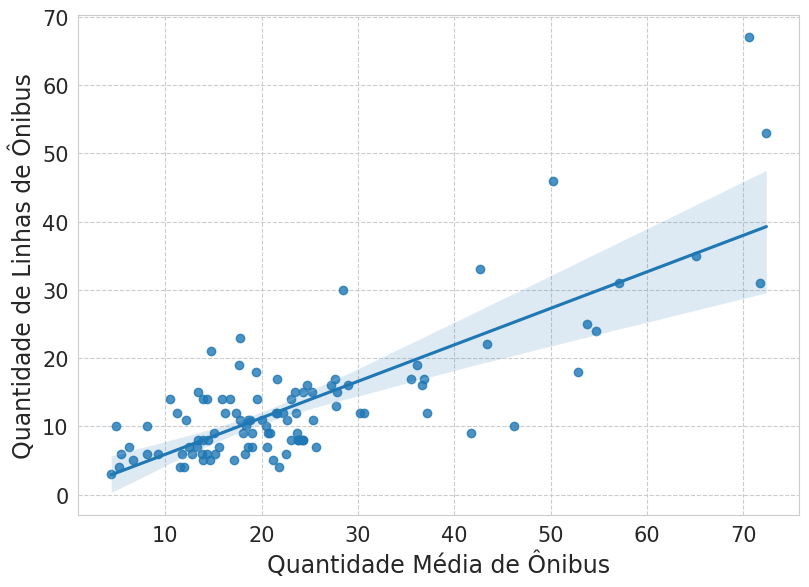

In [66]:
fig, axes = plt.subplots(figsize = (9.3, 6.5))
sns.set_style("whitegrid", {'grid.linestyle': '--'})
g = sns.regplot(x = cluster_metrics.cluster_bus_availability_mean, y = cluster_metrics.cluster_bus_lines, ci = 95, ax = axes)
g.tick_params(labelsize = 15)
g.set_xlabel("Quantidade Média de Ônibus", fontsize = 17)
g.set_ylabel("Quantidade de Linhas de Ônibus", fontsize = 17);
plt.savefig('corr_bus_aval_lines.png', format='png', dpi=300)

In [50]:
mostra_apenas_mapa_calor = False
mostra_apenas_centroid = True

colecao_pontos = []
for index, bus_stop in pd.merge(top, dim_bus_stop, left_on = "dummy_legacy_id", right_on = "legacy_id").iterrows():
    p = Point(bus_stop["longitude"], bus_stop["latitude"])
    colecao_pontos.append({
        "latlong": (p.y, p.x),
        "lat": p.y,
        "long": p.x,
        "geometry": p,
        "weight": bus_stop["mean_bus_availability"]
    })
pontos_calor = gpd.GeoDataFrame(colecao_pontos, crs = "epsg:4326")

colecao_pontos = []
for index, bus_stop in bus_stop_clustered.iterrows():
    p = Point(bus_stop["longitude"], bus_stop["latitude"])
    colecao_pontos.append({
        "latlong": (p.y, p.x),
        "lat": p.y,
        "long": p.x,
        "geometry": p,
        "centre": bus_stop["centre"]
    })
pontos = gpd.GeoDataFrame(colecao_pontos, crs = "epsg:4326")

mapa = folium.Map(
    location = [-25.4284, -49.2733],
    tiles = "OpenStreetMap"
)
HeatMap(pontos_calor[["lat", "long", "weight"]].to_numpy()).add_to(mapa)

if not mostra_apenas_mapa_calor:
    if not mostra_apenas_centroid:

        marker_cluster = MarkerCluster().add_to(mapa)

        folium.GeoJson(
            pontos.query("centre == 0"),
            marker = folium.Marker(
                icon = folium.Icon(
                    color = "blue",
                    prefix = "fa",
                    icon = "bus"
                )
            )
        ).add_to(mapa)

    folium.GeoJson(
        pontos.query("centre == 1"),
        marker = folium.Marker(
            icon = folium.Icon(
                color = "red",
                prefix = "fa",
                icon = "bus"
            )
        )
    ).add_to(mapa)

plugins.Fullscreen(                                                         
        position                = "topright",                                   
        title                   = "Open full-screen map",                       
        title_cancel            = "Close full-screen map",                      
        force_separate_button   = True,                                         
    ).add_to(mapa) 

mapa

In [68]:
import os
import glob
from os.path import join
from pathlib import Path

csv_files = glob.glob(join("correlations_5", "*.csv"))

correlations = []
for f in csv_files:
    aux = Path(f).stem.split("-")
    data = pd.read_csv(f)
    data["centre"] = aux[0]
    data["turno"] = aux[1]
    data["time_window"] = aux[2]
    correlations.append(data)

correlations = pd.concat(correlations, ignore_index = True)
correlations["centre"] = correlations["centre"].astype(np.int64)
correlations["time_window"] = correlations["time_window"].astype(np.int64)
correlations.turno = correlations.turno.replace("Afternoon", "Midday")

In [69]:
# Dicionário de mapeamento para substituir os valores
mapping = {
    "Morning": "Manhã",
    "Midday": "Meio-dia",
    "Evening": "Noite"
}

# Substituindo os valores na coluna 'turno'
correlations['turno'] = correlations['turno'].map(mapping)

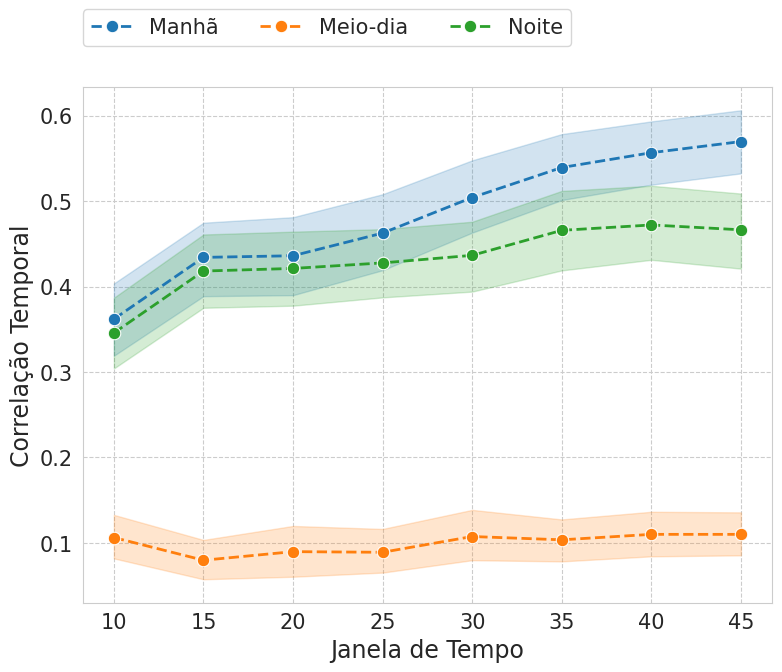

In [71]:
a = correlations.groupby(by = ["centre", "turno", "time_window"]).agg({"correlation": "mean"}).reset_index()
fig, axes = plt.subplots(figsize = (8.9, 6.7))
sns.set_style("whitegrid", {'grid.linestyle': '--'})
g = sns.lineplot(x = a.time_window, y = a.correlation, estimator='mean', err_style = 'band', ci = 95, marker = 'o', markersize = 9, linestyle = "dashed", linewidth = 2, hue = a.turno, hue_order = ["Manhã", "Meio-dia", "Noite"], palette = sns.color_palette("tab10", 3), ax = axes)
g.legend(bbox_to_anchor = (0, 1.15), fontsize = 15, loc = "upper left", ncol = 3, borderaxespad = 0);
g.tick_params(labelsize = 15)
g.set_xlabel("Janela de Tempo", fontsize = 17)
g.set_ylabel("Correlação Temporal", fontsize = 17)
plt.savefig('correlation_time_window.png', format='png', dpi=300);

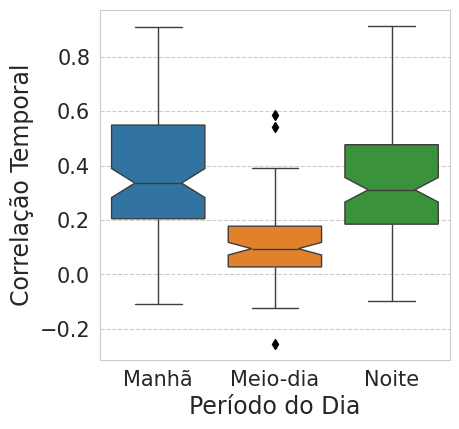

In [87]:
a = correlations.query('time_window == 10').groupby(by = ["centre", "turno", "time_window"]).agg({"correlation": "mean"}).reset_index()
fig, axes = plt.subplots(figsize = (5, 5))
sns.set_style("whitegrid", {'grid.linestyle': '--'})
flierprops = dict(marker = 'd', markerfacecolor = 'black', markersize = 5,  markeredgecolor = 'black')
meanprops = dict(marker = '+', markerfacecolor = 'black', markersize = 10,  markeredgecolor = 'black')
g = sns.boxplot(x = a.turno, y = a.correlation, linewidth = 1.0, notch = True, showfliers = True, order = ["Manhã", "Meio-dia", "Noite"], palette = sns.color_palette("tab10", 3), ax = axes, flierprops = flierprops, meanprops = meanprops)
g.tick_params(labelsize = 15)
g.set_xlabel("Período do Dia", fontsize = 17)
g.set_ylabel("Correlação Temporal", fontsize = 17);
plt.subplots_adjust(left=0.2, right=0.9, bottom=0.2, top=0.9)
fig.savefig('cluster_bus_stop_correlation.png', format='png', dpi=300)